In [6]:
import numpy
import lvmdrp.core.resample as resample
from lvmdrp.core.rss import RSS, loadRSS
import matplotlib.pyplot as plt
from scipy import interpolate
from astropy.io import fits

def interpolate_mask(x, y, mask, kind="linear", fill_value=0):
    """
    :param x, y: numpy arrays, samples and values
    :param mask: boolean mask, True for masked values
    :param method: interpolation method, one of linear, nearest,
    nearest-up, zero, slinear, quadratic, cubic, previous, or next.
    :param fill_value: which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
    :return: the image with missing values interpolated
    """
    if not numpy.any(mask):
        return y
    known_x, known_v = x[~mask], y[~mask]
    missing_x = x[mask]
    missing_idx = numpy.where(mask)

    f = interpolate.interp1d(known_x, known_v, kind=kind, fill_value=fill_value, bounds_error=False)
    yy = y.copy()
    yy[missing_idx] = f(missing_x)

    return yy



# with fits.open("/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/1.1.0dev/1039XX/1039949/60356/lvmCFrame-00012618.fits") as hdu:
#     s1 = hdu['FLUX'].data
#     d1 = hdu['IVAR'].data
#     w1 = hdu['WAVE'].data
f = 1022
f = 1513
# s1 = s1[f,:]
# d1 = d1[f,:]


rss = loadRSS("/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/1.1.0dev/1039XX/1039949/60356/ancillary/lvm-wobject-b-00012618.fits")
s1 = rss._data[f,:]
w1 = rss._wave[f,:]

%matplotlib widget
fig = plt.figure(figsize=(12,5))
#plt.plot(w1, s1, color='red', linewidth=1)
#s1p = interpolate_mask(w1, s1, ~numpy.isfinite(s1))
s1p = s1
#w2 = numpy.logspace(numpy.log10(w1[1]), numpy.log10(w1[-1]), len(w1), endpoint=True)
w2 = numpy.arange(3549.0, 5970.0, 0.5)

# DESI cool histogram hack
s3 = resample.resample_flux_density(w2, w1, s1p, ivar=None)
s_back = resample.resample_flux_density(w1, w2, s3, ivar=None)
#plt.plot(w2, s3, color='cyan', linewidth=1)
#plt.plot(w1, s_back, color='blue', linewidth=1)
plt.plot(w1, (s1p-s_back)/s1p, color='blue', linewidth=1)

# interpolation
inter = interpolate.interp1d(w1, s1p)
s5 = inter(w2)
inter = interpolate.interp1d(w2, s5, bounds_error=0)
s5_back = inter(w1)
#plt.plot(w1, s5_back, color='green', linewidth=1)
plt.plot(w1, (s1p-s5_back)/s1p, color='red', linewidth=1)

print(f'desifast: {numpy.nansum((s1p-s_back)*numpy.gradient(w1))}\n'\
      f'interp  : {numpy.nansum((s1p-s5_back)*numpy.gradient(w1))}\n')

print(f'desifast: {numpy.nansum(s3*numpy.gradient(w2))}\n'\
      f'back    : {numpy.nansum(s_back*numpy.gradient(w1))}\n'\
      f'interp1d: {numpy.nansum(s5*numpy.gradient(w2))}\n'\
      f'int_back: {numpy.nansum(s5_back*numpy.gradient(w1))}\n'\
      f'original: {numpy.nansum(s1p*numpy.gradient(w1))}')
print(w1[0], w1[-1])

[ERROR]: Traceback (most recent call last):
  File "/opt/miniconda/envs/lvmdrp/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/31/fxk1ql6s5bx7q3kh6kwpf8v8c5vp86/T/ipykernel_20174/780522390.py", line 43, in <module>
    rss = loadRSS("/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/1.1.0dev/1039XX/1039949/60356/ancillary/lvm-wobject-b-00012618.fits")
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/droryn/prog/lvm/lvmdrp/python/lvmdrp/core/rss.py", line 3529, in loadRSS
    rss = RSS.from_file(in_rss)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/droryn/prog/lvm/lvmdrp/python/lvmdrp/core/rss.py", line 128, in from_file
    with pyfits.open(in_rss, uint=True, do_not_scale_image_data=True, memmap=False) as hdus:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
from astropy.table import Table
with fits.open("/Users/droryn/prog/lvm/lvmdrp/ckp00_6500.fits") as hdu:
    t = Table(hdu[1].data)
    w = t['WAVELENGTH']
    lvm = numpy.where((w>3600)*(w<9800))
    f = t['g40'][lvm]
    w = w[lvm]
plt.plot(w,f,linewidth=1)

In [ ]:
w1 = numpy.array([0,1,2,3,4,5,6,7,8,9])
w2 = (w1+0.5)
s1p = w2
s1p[5] = numpy.nan

s2 = resample.rebin_spectra(w2, w1, s1p, spec_errs=None, fill=0)

s3 = resample.resample_flux_density(w2, w1, s1p, ivar=None)

s4 = resample.resample_project(w2, w1, s1p, ivar=None)
print(s2,s3,s4)

Alfredo's Test

[WARNING]: /opt/miniconda/envs/lvmdrp/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo



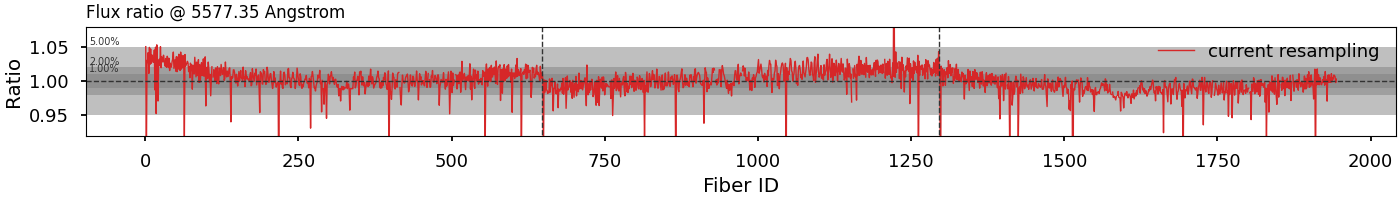

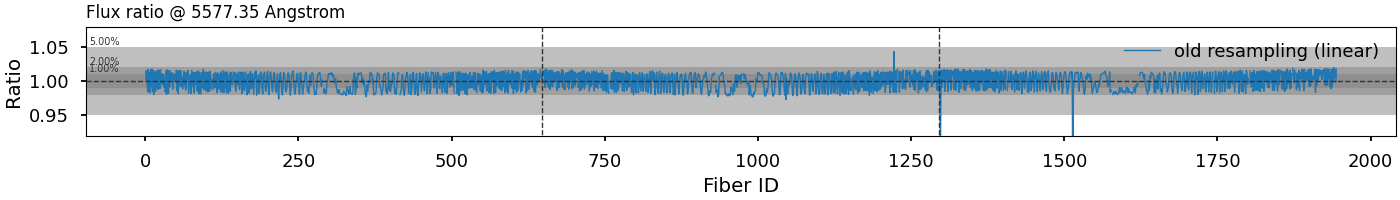

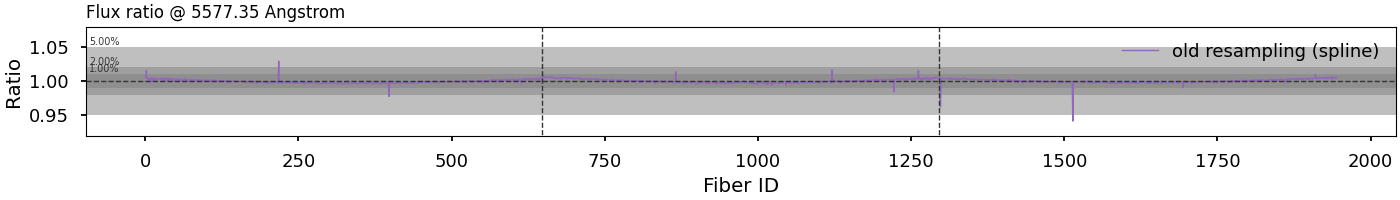

In [7]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload


from lvmdrp.core.constants import SPEC_CHANNELS, SKYLINES_FIBERFLAT
from lvmdrp.core import plot


from lvmdrp.core import rss

channel = "b"
for channel in "b":
    #wframe = rss.RSS.from_file(f"/Volumes/CUCHUFLI/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/1.1.2dev/1055XX/1055752/60578/ancillary/lvm-wobject-{channel}-00026297.fits")
    wframe = rss.RSS.from_file(f"/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/1.1.2dev/1039XX/1039949/60356/ancillary/lvm-wobject-{channel}-00012618.fits")
    hframe_lin = wframe.rectify_wave(wave_range=SPEC_CHANNELS[channel], wave_disp=0.5, method="linear")
    hframe_spl = wframe.rectify_wave(wave_range=SPEC_CHANNELS[channel], wave_disp=0.5, method="spline")
    hframe_niv = wframe.rectify_wave_niv(wave_range=SPEC_CHANNELS[channel], wave_disp=0.5)
    wframe /= np.gradient(wframe._wave, axis=1)

    slitmap = wframe._slitmap
    fibers = slitmap["fiberid"] < 0
    fibers[::648] = True

    ncols = 3
    nrows = int(np.ceil(fibers.sum()/ncols))

    # fig_nat, axs_nat = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows), sharex=True, sharey=True)
    # axs_nat = axs_nat.ravel()
    # fig_nat.suptitle("Non-rectified", fontsize="xx-large")
    # fig_nat.supxlabel("Wavelength (Angstroms)", fontsize="large")
    # axs_nat[0].set_ylabel(f"Flux ({hframe_lin._header['BUNIT']})")

    # fig_lin, axs_lin = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows), sharex=True, sharey=True)
    # axs_lin = axs_lin.ravel()
    # fig_lin.suptitle("Rectified old resampling (linear)", fontsize="xx-large")
    # fig_lin.supxlabel("Wavelength (Angstroms)", fontsize="large")
    # axs_lin[0].set_ylabel(f"Flux ({hframe_lin._header['BUNIT']})")

    # fig_spl, axs_spl = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows), sharex=True, sharey=True)
    # axs_spl = axs_spl.ravel()
    # fig_spl.suptitle("Rectified old resampling (spline)", fontsize="xx-large")
    # fig_spl.supxlabel("Wavelength (Angstroms)", fontsize="large")
    # axs_spl[0].set_ylabel(f"Flux ({hframe_lin._header['BUNIT']})")

    # fig_niv, axs_niv = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows), sharex=True, sharey=True)
    # axs_niv = axs_niv.ravel()
    # fig_niv.suptitle("Rectified current resampling", fontsize="xx-large")
    # fig_niv.supxlabel("Wavelength (Angstroms)", fontsize="large")
    # axs_niv[0].set_ylabel(f"Flux ({hframe_lin._header['BUNIT']})")

    z_nat = wframe.fit_lines_slit(cwaves=SKYLINES_FIBERFLAT[channel], dwave=20)#, select_fibers=fibers, axs=axs_nat)
    z_lin = hframe_lin.fit_lines_slit(cwaves=SKYLINES_FIBERFLAT[channel], dwave=20)#, select_fibers=fibers, axs=axs_lin)
    z_spl = hframe_spl.fit_lines_slit(cwaves=SKYLINES_FIBERFLAT[channel], dwave=20)#, select_fibers=fibers, axs=axs_spl)
    z_niv = hframe_niv.fit_lines_slit(cwaves=SKYLINES_FIBERFLAT[channel], dwave=20)#, select_fibers=fibers, axs=axs_niv)
    # fig_nat.tight_layout()
    # fig_lin.tight_layout()
    # fig_spl.tight_layout()
    # fig_niv.tight_layout()

    _, ax = plt.subplots(figsize=(14,2), layout="constrained")
    plot.slit(x=slitmap["fiberid"].data, y=z_nat / z_niv, ax=ax, color="tab:red", label="current resampling")
    ax.legend(loc=1, frameon=False, ncols=5)
    ax.set_ylim(0.92, 1.08)
    ax.set_xlabel("Fiber ID")
    ax.set_ylabel("Ratio")
    ax.set_title(f"Flux ratio @ {SKYLINES_FIBERFLAT[channel]:.2f} Angstrom", loc="left", fontsize="large")

    _, ax = plt.subplots(figsize=(14,2), layout="constrained")
    plot.slit(x=slitmap["fiberid"].data, y=z_nat / z_lin, ax=ax, color="tab:blue", label="old resampling (linear)")
    ax.legend(loc=1, frameon=False, ncols=5)
    ax.set_ylim(0.92, 1.08)
    ax.set_xlabel("Fiber ID")
    ax.set_ylabel("Ratio")
    ax.set_title(f"Flux ratio @ {SKYLINES_FIBERFLAT[channel]:.2f} Angstrom", loc="left", fontsize="large")

    _, ax = plt.subplots(figsize=(14,2), layout="constrained")
    plot.slit(x=slitmap["fiberid"].data, y=z_nat / z_spl, ax=ax, color="tab:purple", label="old resampling (spline)")
    ax.legend(loc=1, frameon=False, ncols=5)
    ax.set_ylim(0.92, 1.08)
    ax.set_xlabel("Fiber ID")
    ax.set_ylabel("Ratio")
    ax.set_title(f"Flux ratio @ {SKYLINES_FIBERFLAT[channel]:.2f} Angstrom", loc="left", fontsize="large")


In [8]:
"""
Provides a set of functions to handle resampling.
"""
import warnings
import numpy
from scipy import interpolate



def grid_npix(rng=None, dx=None, log=False, base=10.0, default=None):
    """
    Determine the number of pixels needed for a given grid.

    Args:
        rng (array-like, optional):
            Two-element array with the
            starting and ending x coordinate of the pixel centers to
            divide into pixels of a given width.  If *log* is True, this
            must still be the linear value of the x coordinate, not
            log(x)!.
        dx (:obj:`float`, optional):
            Linear or logarithmic pixel width.
        log (:obj:`bool`, optional):
            Flag that the range should be logarithmically binned.
        base (:obj:`float`, optional):
            Base for the logarithm
        default (:obj:`int`, optional):
            Default number of pixels to use. The default is returned
            if either ``rng`` or ``dx`` are not provided.

    Returns:
        :obj:`tuple`: Returns the number of pixels to cover ``rng``
        with pixels of width ``dx`` and a two-element
        `numpy.ndarray`_ with the adjusted range such that number of
        pixels of size dx is the exact integer.

    Raises:
        ValueError:
            Raised if the range is not a two-element vector.
    """
    # If the range or sampling are not provided, the number of pixels is
    # already set
    if rng is None or dx is None:
        return default, rng
    if len(rng) != 2:
        raise ValueError('Range must be a 2-element vector.')

    _rng = numpy.atleast_1d(rng).copy()
    npix = int(numpy.floor(numpy.diff(numpy.log(_rng))[0]/numpy.log(base)/dx) + 1) if log else \
                    int(numpy.floor(numpy.diff(_rng)[0]/dx) + 1)
    _rng[1] = numpy.power(base, numpy.log(_rng[0])/numpy.log(base) + dx*(npix-1)) \
                            if log else _rng[0] + dx*(npix-1)

    # Fix for numerical precision
    if (not log and numpy.isclose(rng[1] - _rng[1], dx)) \
           or (log and numpy.isclose((numpy.log(rng[1]) - numpy.log(_rng[1]))/numpy.log(base), dx)):
        npix += 1
        _rng[1] = numpy.power(base, numpy.log(_rng[0])/numpy.log(base) + dx*(npix-1)) \
                                if log else _rng[0] + dx*(npix-1)

    return npix, _rng


def grid_borders(rng, npix, log=False, base=10.0):
    """
    Determine the borders of bin edges in a grid.

    Args:
        rng (array-like):
            Two-element array with the (geometric) centers of the
            first and last pixel in the grid.
        npix (:obj:`int`):
            Number of pixels in the grid.
        log (:obj:`bool`, optional):
            The input range is (to be) logarithmically sampled.
        base (:obj:`float`, optional):
            The base of the logarithmic sampling. Use
            ``numpy.exp(1.)`` for the natural logarithm.

    Returns:
        :obj:`tuple`: Returns a `numpy.ndarray`_ with the grid
        borders with shape ``(npix+1,)`` and the step size per grid
        point. If ``log=True``, the latter is the geometric step.
    """
    if log:
        _rng = numpy.log(rng)/numpy.log(base)
        dlogx = numpy.diff(_rng)[0]/(npix-1.)
        borders = numpy.power(base, numpy.linspace(*(_rng/dlogx + [-0.5, 0.5]), num=npix+1)*dlogx)
        return borders, dlogx
    dx = numpy.diff(rng)[0]/(npix-1.)
    borders = numpy.linspace(*(numpy.atleast_1d(rng)/dx + numpy.array([-0.5, 0.5])), num=npix+1)*dx
    return borders, dx


def grid_centers(rng, npix, log=False, base=10.0):
    """
    Determine the (geometric) center of pixels in a grid.

    Args:
        rng (array-like):
            Two-element array with the (geometric) centers of the
            first and last pixel in the grid.
        npix (:obj:`int`):
            Number of pixels in the grid.
        log (:obj:`bool`, optional):
            The input range is (to be) logarithmically sampled.
        base (:obj:`float`, optional):
            The base of the logarithmic sampling. Use
            ``numpy.exp(1.)`` for the natural logarithm.

    Returns:
        :obj:`tuple`: Returns a `numpy.ndarray`_ with the grid pixel
        (geometric) ceners with shape ``(npix,)`` and the step size
        per grid point. If ``log=True``, the latter is the geometric
        step.
    """
    if log:
        _rng = numpy.log(rng)/numpy.log(base)
        dlogx = numpy.diff(_rng)[0]/(npix-1.)
        centers = numpy.power(base, numpy.linspace(*(_rng/dlogx), num=npix)*dlogx)
        return centers, dlogx
    dx = numpy.diff(rng)[0]/(npix-1.)
    centers = numpy.linspace(*(numpy.atleast_1d(rng)/dx), num=npix)*dx
    return centers, dx


def borders_to_centers(borders, log=False):
    """
    Convert a set of bin borders to bin centers.

    Grid borders need not be regularly spaced.

    Args:
        borders (`numpy.ndarray`_):
            Borders for adjoining bins.
        log (:obj:`bool`, optional):
            Return the geometric center instead of the linear center
            of the bins.

    Returns:
        `numpy.ndarray`_: The vector of bin centers.
    """
    return numpy.sqrt(borders[:-1]*borders[1:]) if log else (borders[:-1]+borders[1:])/2.0


def centers_to_borders(x, log=False):
    """
    Convert a set of bin centers to bounding edges.

    Grid centers need not be regularly spaced. The first edge of the
    first bin and the last edge of the last bin are assumed to be
    equidistant from the center of the 2nd and penultimate bins,
    respectively.

    Args:
        x (`numpy.ndarray`_):
            Centers of adjoining bins.
        log (:obj:`bool`, optional):
            Adopt a geometric binning instead of a linear binning.

    Returns:
        `numpy.ndarray`_: The vector with the coordinates of
        adjoining bin edges.
    """
    if log:
        dx = numpy.diff(numpy.log(x))
        return numpy.exp(numpy.append(numpy.log(x[:-1]) - dx/2,
                                      numpy.log(x[-1]) + numpy.array([-1,1])*dx[-1]/2))
    dx = numpy.diff(x)
    return numpy.append(x[:-1] - dx/2, x[-1] + numpy.array([-1,1])*dx[-1]/2)


class Resample:
    r"""
    Resample regularly or irregularly sampled data to a new grid using
    integration.
    
    This is a generalization of the routine
    :func:`ppxf.ppxf_util.log_rebin` provided by Michele Cappellari in
    the pPXF package.

    The abscissa coordinates (``x``) or the pixel borders
    (``xBorders``) for the data (``y``) should be provided for
    irregularly sampled data. If the input data is linearly or
    geometrically sampled (``inLog=True``), the abscissa coordinates
    can be generated using the input range for the (geometric) center
    of each grid point. If ``x``, ``xBorders``, and ``xRange`` are
    all None, the function assumes grid coordinates of ``x =
    numpy.arange(y.shape[-1])``.

    The function resamples the data by constructing the borders of
    the output grid using the ``new*`` keywords and integrating the
    input function between those borders. The output data will be set
    to ``ext_value`` for any data beyond the abscissa limits of the
    input data.

    The data to resample (``y``) can be a 1D or 2D array; the
    abscissa coordinates must always be 1D. If ``y`` is 2D, the
    resampling is performed along the last axis (i.e., ``axis=-1``).

    The nominal assumption is that the provided function is a step
    function based on the provided input (i.e., ``step=True``). If
    the output grid is substantially finer than the input grid, the
    assumption of a step function will be very apparent. To assume
    the function is instead linearly interpolated between each
    provided point, choose ``step=False``; higher-order
    interpolations are not provided.

    If errors are provided, a nominal error propagation is performed
    to provide the errors in the resampled data.

    .. warning::

        Depending on the details of the resampling, the output errors
        are likely highly correlated.  Any later analysis of the
        resampled function should account for this.

    The covariance in the resampled pixels can be constructed by
    setting ``covar=True``; however, this is currently only supported
    when ``step=True``. If no errors are provided and ``covar=True``,
    the computed matrix is the *correlation* matrix instead of the
    *covariance* matrix. Given that the resampling is the same for all
    vectors, only one correlation matix will be calculated if no
    errors are provided, even if the input ``y`` is 2D. If the input
    data to be resampled is 2D and errors *are* provided, a
    covariance matrix is calculated for *each* vector in ``y``.
    Beware that this can be an expensive computation.

    The ``conserve`` keyword sets how the units of the input data
    should be treated. If ``conserve=False``, the input data are
    expected to be in density units (i.e., per ``x`` coordinate unit)
    such that the integral over :math:`dx` is independent of the
    units of :math:`x` (i.e., flux per unit angstrom or flux
    density). If ``conserve=True``, the value of the data is assumed
    to have been integrated over the size of each pixel (i.e., units
    of flux). If ``conserve=True``, :math:`y` is converted to units
    of per step in :math:`x` such that the integral before and after
    the resample is the same. For example, if :math:`y` is a spectrum
    in units of flux, the function first converts the units to flux
    density and then computes the integral over each new pixel to
    produce the new spectra with units of flux.

    Args:
        y (`numpy.ndarray`_, `numpy.ma.MaskedArray`_):
            Data values to resample. The shape can be 1D or 2D. If
            1D, the shape must be :math:`(N_{\rm pix},)`; otherwise,
            it must be :math:`(N_y,N_{\rm pix})`. I.e., the length of
            the last axis must match the input coordinates.
        e (`numpy.ndarray`_, `numpy.ma.MaskedArray`_, optional):
            Errors in the data that should be resampled. The shape
            must match the input ``y`` array. These data are used to
            perform a nominal calculation of the error in the
            resampled array.
        mask (`numpy.ndarray`_, optional):
            A boolean array indicating values in ``y`` that should be
            ignored during the resampling (values to ignore have
            ``masked=True``, just like in a `numpy.ma.MaskedArray`_).
            The mask used during the resampling is the union of this
            object and the masks of ``y`` and ``e``, if either are
            provided as `numpy.ma.MaskedArray`_ objects.
        x (`numpy.ndarray`_, optional):
            Abscissa coordinates for the data, which do not need to
            be regularly sampled. If the pixel borders are not
            provided, they are assumed to be half-way between
            adjacent pixels, and the first and last borders are
            assumed to be equidistant about the provided value. If
            these coordinates are not provided, they are determined
            by the input borders, the input range, or just assumed to
            be the indices, :math:`0..N_{\rm pix}-1`.
        xRange (array-like, optional):
            A two-element array with the starting and ending value
            for the coordinates of the centers of the first and last
            pixels in ``y``. Default is :math:`[0,N_{\rm pix}-1]`.
        xBorders (`numpy.ndarray`_, optional):
            An array with the borders of each pixel that must have a
            length of :math:`N_{\rm pix}+1`.
        inLog (:obj:`bool`, optional):
            Flag that the input is logarithmically binned, primarily
            meaning that the coordinates are at the geometric center
            of each pixel and the centers are spaced logarithmically.
            If false, the sampling is expected to be linear.
        newx (array-like, optional):
            Abscissa coordinates for the *output* data, which do not
            need to be a regular grid. If this is provided, the pixel
            borders are assumed to be half-way between adjacent
            pixels, and the first and last borders are assumed to be
            equidistant about the provided value. If these
            coordinates are not provided, they are determined by the
            new range, the new number of pixels, and/or the new pixel
            width (and whether or not the new grid should be
            logarithmically binned). If this is provided,
            ``newRange``, ``newpix``, ``newLog``, and ``newdx`` are
            *all* ignored.
        newRange (array-like, optional):
            A two-element array with the (geometric) centers of the
            first and last pixel in the output vector. If not
            provided, assumed to be the same as the input range.
        newBorders (array-like, optional):
            An array with the borders of each pixel in the resampled
            vectors.
        newpix (:obj:`int`, optional): 
            Number of pixels for the output vector.  If not provided,
            assumed to be the same as the input vector.
        newLog (:obj:`bool`, optional):
            The output vector should be logarithmically binned.
        newdx (:obj:`float`, optional):
            The sampling step for the output vector. If
            `newLog=True`, this must be the change in the *logarithm*
            of :math:`x` for the output vector! If not provided, the
            sampling is set by the output range (see ``newRange``
            above) and number of pixels (see ``newpix`` above).
        base (:obj:`float`, optional):
            The base of the logarithm used for both input and output
            sampling, if specified. The default is 10; use
            ``numpy.exp(1)`` for natural logarithm.
        ext_value (:obj:`float`, optional):
            Set extrapolated values to the provided float. If set to
            None, values are just set to the linear extrapolation of
            the data beyond the provided limits; use `ext_value=None`
            with caution!
        conserve (:obj:`bool`, optional):
            Conserve the integral of the input vector.  For example, if
            the input vector is a spectrum in flux units, you should
            conserve the flux in the resampling; if the spectrum is in
            units of flux density, you do not want to conserve the
            integral.
        step (:obj:`bool`, optional):
            Treat the input function as a step function during the
            resampling integration.  If False, use a linear
            interpolation between pixel samples.
    
    Attributes:
        x (`numpy.ndarray`_):
            The coordinates of the function on input.
        xborders (`numpy.ndarray`_):
            The borders of the input pixel samples.
        y (`numpy.ndarray`_):
            The function to resample.
        e (`numpy.ndarray`_):
            The 1-sigma errors in the function to resample.
        m (`numpy.ndarray`_):
            The boolean mask for the input function.
        outx (`numpy.ndarray`_):
            The coordinates of the function on output.
        outborders (`numpy.ndarray`_):
            The borders of the output pixel samples.
        outy (`numpy.ndarray`_):
            The resampled function.
        oute (`numpy.ndarray`_):
            The resampled 1-sigma errors.
        outf (`numpy.ndarray`_):
            The fraction of each output pixel that includes valid data
            from the input function.

    Raises:
        ValueError:
            Raised if more the one of ``x``, ``xRange``, or
            ``xBorders`` are provided, if more the one of ``newx``,
            ``newRange``, or ``newBorders`` are provided, if ``y`` is
            a `numpy.ndarray`_, if ``y`` is not 1D or 2D, if the
            covariance is requested but ``step`` is False, if the
            shapes of the provided errors or mask do not match ``y``,
            if there is insufficient information to construct the
            input or output grid, or if either ``xRange`` or
            ``newRange`` are not two-element arrays.
    """
    def __init__(self, y, e=None, mask=None, x=None, xRange=None, xBorders=None, inLog=False,
                 newx=None, newRange=None, newBorders=None, newpix=None, newLog=True, newdx=None,
                 base=10.0, ext_value=0.0, conserve=False, step=True):

        # Check operation can be performed and is not ill-posed
        if numpy.sum([inp is not None for inp in [x, xRange, xBorders]]) != 1:
            raise ValueError('One and only one of the x, xRange, and xBorders arguments should be '
                             'provided.')
        if numpy.sum([inp is not None for inp in [newx, newRange, newBorders]]) != 1:
            raise ValueError('One and only one of the newx, newRange, and newBorders arguments '
                             'should be provided.')
        if not isinstance(y, numpy.ndarray):
            raise ValueError('Input vector must be a numpy.ndarray!')
        if y.ndim > 2:
            raise ValueError('Input must be a 1D or 2D array!')

        # Setup the data, errors, and mask
        self.y = y.filled(0.0) if isinstance(y, numpy.ma.MaskedArray) else y.copy()
        self.twod = self.y.ndim == 2
        self.e = None if e is None \
                    else e.filled(0.0) if isinstance(e, numpy.ma.MaskedArray) else e.copy()
        self.m = numpy.zeros(self.y.shape, dtype=bool) if mask is None else mask

        # Check the shapes
        if self.e is not None and self.e.shape != self.y.shape:
            raise ValueError('Error array shape mismatched!')
        if self.m.shape != self.y.shape:
            raise ValueError('Mask array shape mismatched!')

        # Get the union of all the relevant masks
        if isinstance(y, numpy.ma.MaskedArray):
            self.m |= y.mask
        if e is not None and isinstance(e, numpy.ma.MaskedArray):
            self.m |= e.mask

        # Get the input coordinates
        nx = self.y.shape[-1] if x is None and xBorders is None else None
        self.x, self.xborders = self._coordinate_grid(x=x, rng=xRange, nx=nx, borders=xBorders,
                                                      log=inLog, base=base)

        # If conserving integral, assume input is integrated over pixel
        # width and convert to a density function (divide by pixel size)
        if conserve:
            self.y /= (numpy.diff(self.xborders)[None,:] if self.twod \
                                else numpy.diff(self.xborders))

        # Get the output coordinates
        nx = self.x.size \
                if newx is None and newBorders is None and newpix is None and newdx is None \
                else newpix
        self.outx, self.outborders = self._coordinate_grid(x=newx, rng=newRange, nx=nx,
                                                           borders=newBorders, dx=newdx,
                                                           log=newLog, base=base)

        # Perform the resampling
        self.outy = self._resample_step(self.y) if step else self._resample_linear(self.y)
    
        # The mask and errors are always interpolated as a step function
        self.oute = None if self.e is None else self._resample_step(self.e, quad=True)
    
        self.outf = self._resample_step(numpy.logical_not(self.m).astype(int)) \
                        / numpy.diff(self.outborders)

        # Do not conserve the integral over the size of the pixel
        if not conserve:
            self.outy /= (numpy.diff(self.outborders)[None,:] if self.twod \
                            else numpy.diff(self.outborders))
            if self.oute is not None:
                self.oute /= (numpy.diff(self.outborders)[None,:] if self.twod \
                                    else numpy.diff(self.outborders))

        # Set values for extrapolated regions
        if ext_value is not None:
            indx = (self.outborders[:-1] < self.xborders[0]) \
                        | (self.outborders[1:] > self.xborders[-1]) 
            if numpy.sum(indx) > 0:
                self.outy[...,indx] = ext_value
                self.outf[...,indx] = 0.
                if self.oute is not None:
                    self.oute[...,indx] = 0.

    @staticmethod
    def _coordinate_grid(x=None, rng=None, nx=None, dx=None, borders=None, log=False, base=10.0):
        """
        Use the provided information to construct the coordinate grid
        and the grid borders.
        """
        if x is not None and borders is not None:
            raise ValueError('Both x and borders provided.  Do not need to call _coordinate_grid, '
                             'but also _coordinate_grid does not check that x and borders are '
                             'consistenet with one another.')
        if (x is not None or borders is not None) and rng is not None:
            warnings.warn('Provided both x or borders and the range.  Ignoring range.')
        if x is None and borders is not None:
            # Use the borders to set the centers
            return borders_to_centers(borders, log=log), borders
        if x is not None and borders is None:
            # Use the centers to set the borders
            return x, centers_to_borders(x, log=log)

        # After this point, both x and borders should be None
        assert x is None and borders is None, 'Coding logic error'

        if rng is None and nx is None:
            raise ValueError('Insufficient input to construct coordinate grid.')

        if rng is None:
            # Just set the result to a uniform pixel grid
            return numpy.arange(nx, dtype=float) + 0.5, numpy.arange(nx+1, dtype=float)

        # After this point, rng cannot be None
        assert rng is not None, 'Coding logic error'

        if dx is not None and nx is not None:
            warnings.warn('Provided rng, dx, and nx, which over-specifies the grid; rng and nx '
                          'take precedence.')
        if nx is not None:
            borders = grid_borders(rng, nx, log=log, base=base)[0]
            return borders_to_centers(borders, log=log), borders

        nx, _rng = grid_npix(rng=rng, dx=dx, log=log, base=base)
        borders = grid_borders(_rng, nx, log=log, base=base)[0]
        return borders_to_centers(borders, log=log), borders

    def _resample_linear(self, v, quad=False):
        """Resample the vectors."""

        # Combine the input coordinates and the output borders
        combinedX = numpy.append(self.outborders, self.x)
        srt = numpy.argsort(combinedX)
        combinedX = combinedX[srt]

        # Get the indices where the data should be reduced
        border = numpy.ones(combinedX.size, dtype=bool)
        border[self.outborders.size:] = False
        k = numpy.arange(combinedX.size)[border[srt]]

        # Calculate the integrand
        if self.twod:
            # Linearly interpolate the input function at the output border positions
            interp = interpolate.interp1d(self.x, v, axis=-1, assume_sorted=True,
                                          fill_value='extrapolate')
            combinedY = numpy.append(interp(self.outborders), v, axis=-1)[:,srt]
            integrand = (combinedY[:,1:]+combinedY[:,:-1])*numpy.diff(combinedX)[None,:]/2.0
        else:
            # Linearly interpolate the input function at the output border positions
            interp = interpolate.interp1d(self.x, v, assume_sorted=True,
                                          fill_value='extrapolate')
            combinedY = numpy.append(interp(self.outborders), v)[srt]
            integrand = (combinedY[1:]+combinedY[:-1])*numpy.diff(combinedX)/2.0

        if quad:
            integrand = numpy.square(integrand)

        # Use reduceat to calculate the integral
        out = numpy.add.reduceat(integrand, k[:-1], axis=-1) if k[-1] == combinedX.size-1 \
                        else numpy.add.reduceat(integrand, k, axis=-1)[...,:-1]
    
        return numpy.sqrt(out) if quad else out

    def _resample_step(self, v, quad=False):
        """Resample the vectors."""

        # Convert y to a step function
        #  - repeat each element of the input vector twice
        _v = numpy.repeat(v, 2, axis=1) if self.twod else numpy.repeat(v, 2)
        #  - repeat each element of the border array twice, and remove
        #  the first and last elements
        _x = numpy.repeat(self.xborders, 2)[1:-1]

        # Combine the input coordinates and the output borders into a
        # single vector
        indx = numpy.searchsorted(_x, self.outborders)
        combinedX = numpy.insert(_x, indx, self.outborders)

        # Insert points at the borders of the output function
        v_indx = indx.copy()
        v_indx[indx >= _v.shape[-1]] = -1
        combinedY = numpy.array([ numpy.insert(__v, indx, __v[v_indx]) for __v in _v ]) \
                            if self.twod else numpy.insert(_v, indx, _v[v_indx])

        # Calculate the integrand
        integrand = combinedY[:,1:]*numpy.diff(combinedX)[None,:] if self.twod else \
                        combinedY[1:]*numpy.diff(combinedX)
        if quad:
            integrand = numpy.square(integrand)

        # Get the indices where the data should be reduced
        border = numpy.insert(numpy.zeros(_x.size, dtype=bool), indx,
                              numpy.ones(self.outborders.size, dtype=bool))
        k = numpy.arange(combinedX.size)[border]

        # Use reduceat to calculate the integral
        out = numpy.add.reduceat(integrand, k[:-1], axis=-1) if k[-1] == combinedX.size-1 \
                    else numpy.add.reduceat(integrand, k, axis=-1)[...,:-1]
        return numpy.sqrt(out) if quad else out

    def _resample_step_matrix(self):
        r"""
        Build a matrix such that

        .. math::
            y = \mathbf{A} x

        where :math:`x` is the input vector, :math:`y` is the resampled
        vector, and :math:`\mathbf{A}` is the matrix operations that
        resamples :math:`x`.
        """
        ny = self.outx.size
        nx = self.x.size

        # Repeat each element of the border array twice, and remove the
        # first and last elements
        _p = numpy.repeat(numpy.arange(self.x.size), 2)
        _x = numpy.repeat(self.xborders, 2)[1:-1]

        # Combine the input coordinates and the output borders into a
        # single vector
        indx = numpy.searchsorted(_x, self.outborders)
        combinedX = numpy.insert(_x, indx, self.outborders)

        # Insert points at the borders of the output function
        p_indx = indx.copy()
        p_indx[indx >= _p.shape[-1]] = -1
        combinedP = numpy.insert(_p, indx, _p[p_indx])

        # Get the indices where the data should be reduced
        border = numpy.insert(numpy.zeros(_x.size, dtype=bool), indx,
                              numpy.ones(self.outborders.size, dtype=bool))
        nn = numpy.where(numpy.logical_not(border))[0][::2]
        k = numpy.zeros(len(combinedX), dtype=int)
        k[border] = numpy.arange(numpy.sum(border))
        k[nn-1] = k[nn-2]
        k[nn] = k[nn-1]
        start,end = numpy.where(border)[0][[0,-1]]

        # Calculate the fraction of each pixel into each output pixel
        fraction = numpy.diff(combinedX[start:end+1])
        # Construct the output matrix
        indx = fraction > 0
        A = numpy.zeros((ny, nx), dtype=float)
        A[k[start:end][indx], combinedP[start:end][indx]] = fraction[indx]
        return A





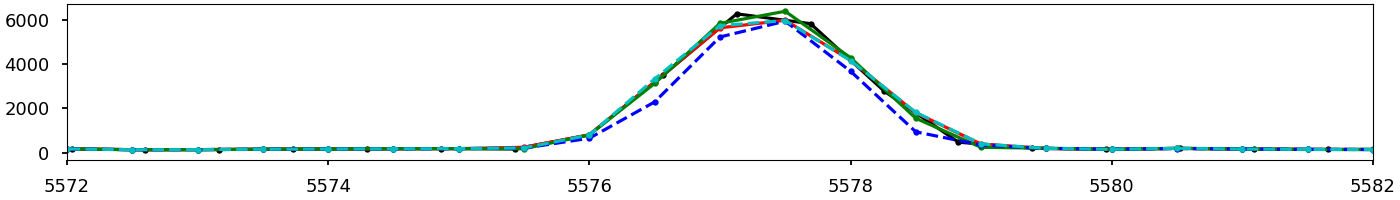

In [9]:
%matplotlib widget
plt.cla()
fiber = 99
plt.plot(wframe._wave[fiber,:], wframe._data[fiber,:], 'k-')
plt.plot(wframe._wave[fiber,:], wframe._data[fiber,:], 'k.')
plt.plot(hframe_lin._wave[:], hframe_lin._data[fiber,:], 'r-')
plt.plot(hframe_lin._wave[:], hframe_lin._data[fiber,:], 'r.')
plt.plot(hframe_spl._wave[:], hframe_spl._data[fiber,:], 'g-')
plt.plot(hframe_spl._wave[:], hframe_spl._data[fiber,:], 'g.')
plt.plot(hframe_niv._wave[:], hframe_niv._data[fiber,:], 'b--')
plt.plot(hframe_niv._wave[:], hframe_niv._data[fiber,:], 'b.')

r = Resample(wframe._data[fiber,:], None, None, wframe._wave[fiber,:], newx=hframe_lin._wave[:])
plt.plot(r.outx, r.outy, 'c--')
plt.plot(r.outx, r.outy, 'c.')

plt.xlim(5572,5582)

plt.show()